# Car Price Prediction

- Student name: Jagandeep Singh
- Student pace: full-time
- Scheduled project review date: 31 July
- Instructor name: Sean Wilson

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.dummy import DummyRegressor
import scipy.stats as stats
from statsmodels.formula.api import ols
import statsmodels.api as sm
from sklearn.model_selection import train_test_split
from sklearn import linear_model
from sklearn import metrics
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import StandardScaler
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.feature_selection import SelectKBest, f_regression,mutual_info_regression
from sklearn.feature_selection import RFECV
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import Lasso
from sklearn.preprocessing import MinMaxScaler
pd.set_option('display.max_columns', None)
plt.style.use('seaborn-deep')
plt.rcParams.update({'font.size': 15})

In [2]:
df = pd.read_csv('vehicles.csv')

In [3]:
df.shape

(435849, 25)

## Data Cleaning

In [4]:
# Removing rows with missing price and year
df.drop(df[df['price'] == 0].index, inplace = True) 
df.drop(df[df['year'].isna()].index, inplace = True) 
df.drop(df[df['year'] == 2021].index, inplace = True)
df.drop([496], inplace = True)
df.drop(df[df.odometer > 500000].index, inplace = True)

In [5]:
# Changing type of year to int
df['year'] = df['year'].astype(int)
df['year'].dtype

dtype('int64')

In [6]:
year_med =  dict(df.groupby('year')['odometer'].median())

In [7]:
# Imputing missing values in odometer with median odometer of each year cars
df['odometer'] = df['odometer'].fillna(df['year'].apply(lambda x: year_med.get(x)))

In [8]:
# Removing the leftover missing values in odometer because no information available for those years
df.drop(df[df['odometer'].isna()].index, inplace = True) 

In [9]:
df.shape

(402995, 25)

In [10]:
# Dropping cars with price less than 1000 with miles less than 60,000 and model year greater than 2010
df.drop(df[(df.price < 1000 ) & (df.odometer < 60000 ) & (df.year > 2010)].index, inplace = True)
df.drop(df[(df.price < 200)].index, inplace = True)
df.drop(df[(df.price > 50000)].index, inplace = True)

In [11]:
df.shape

(391442, 25)

In [12]:
df.head()

,id,url,region,region_url,price,year,manufacturer,model,condition,cylinders,fuel,odometer,title_status,transmission,vin,drive,size,type,paint_color,image_url,description,county,state,lat,long
0,7119256118,https://mohave.craigslist.org/ctd/d/lake-havas...,mohave county,https://mohave.craigslist.org,3495,2012,jeep,patriot,like new,4 cylinders,gas,104259.0,clean,automatic,NaN,NaN,NaN,NaN,silver,https://images.craigslist.org/00B0B_k2AXIJ21ok...,"THIS 2012 JEEP PATRIOT IS A 4CYL. AC, STEREO, ...",NaN,az,34.4554,-114.2690
1,7120880186,https://oregoncoast.craigslist.org/cto/d/warre...,oregon coast,https://oregoncoast.craigslist.org,13750,2014,bmw,328i m-sport,good,NaN,gas,76237.0,clean,automatic,NaN,rwd,NaN,sedan,grey,https://images.craigslist.org/00U0U_3cLk0WGOJ8...,Selling my 2014 BMW 328i with the following be...,NaN,or,46.1837,-123.8240
2,7115048251,https://greenville.craigslist.org/cto/d/sparta...,greenville / upstate,https://greenville.craigslist.org,2300,2001,dodge,caravan,excellent,6 cylinders,gas,199000.0,clean,automatic,NaN,NaN,NaN,NaN,NaN,https://images.craigslist.org/00k0k_t4WqYn5nDC...,"01 DODGE CARAVAN,3.3 ENGINE,AUT TRANS,199000 M...",NaN,sc,34.9352,-81.9654
3,7119250502,https://mohave.craigslist.org/cto/d/lake-havas...,mohave county,https://mohave.craigslist.org,9000,2004,chevrolet,colorado ls,excellent,5 cylinders,gas,54000.0,clean,automatic,1GCCS196448191644,rwd,mid-size,pickup,red,https://images.craigslist.org/00J0J_lJEzfeVLHI...,"2004 Chevy Colorado LS, ONLY 54000 ORIGINAL MI...",NaN,az,34.4783,-114.2710
5,7120432569,https://maine.craigslist.org/ctd/d/bad-credit-...,maine,https://maine.craigslist.org,500,2010,NaN,$500 DOWN PROGRAMS!!!,NaN,NaN,gas,120757.0,clean,automatic,NaN,NaN,NaN,NaN,NaN,https://images.craigslist.org/01010_7qTZ8KZK03...,☛WE have 100's OF VEHICLES to choose from! CAL...,NaN,me,42.8424,-71.1077


In [13]:
# Dropping rows with missing cylinders, transmission and drive
df.drop(df[(df['cylinders'].isna()) & (df['transmission'].isna()) & (df['drive'].isna())].index, inplace = True)

In [14]:
df['cylinders'] = df['cylinders'].apply(lambda x: x[0] if not pd.isnull(x) else np.nan)

In [15]:
# Changing cylinders of tesla cars to 0
df.loc[df.manufacturer == 'tesla', 'cylinders'] = 0
df.cylinders.fillna(0, inplace = True)
df.cylinders =  df.cylinders.replace('o', 0)

In [16]:
df['cylinders'] = df['cylinders'].astype(int)


In [17]:
# Changing cylinder of all 2019 honda accords to 4
df.loc[((df.manufacturer == 'honda') & (df.year == 2019) & (df.model == 'accord')), 'cylinders'] = 4

In [18]:
df.loc[((df.manufacturer == 'honda') & (df.year == 2020) & (df.model == 'accord')),'cylinders'] = 4

In [19]:
# Dropping unwanted columns
df.drop(['id', 'url', 'region_url', 'vin', 'county', 'lat', 'long','image_url', 'region'], axis = 1, inplace = True) 

In [20]:
df.shape

(390671, 16)

In [21]:
df.isna().sum()

price                0
year                 0
manufacturer     15695
model             5492
condition       157235
cylinders            0
fuel              2158
odometer             0
title_status      1130
transmission      1043
drive           106431
size            263842
type            104388
paint_color     117768
description          2
state                0
dtype: int64

In [22]:
# filling missing condition values with fair considering their condition would be fair
#df.condition.fillna('fair', inplace = True)

In [23]:
df.condition.replace('like new', 'excellent', inplace = True)
df.condition.replace('new', 'excellent', inplace = True)

In [24]:
df.condition.value_counts()

excellent    135595
good          90407
fair           6776
salvage         658
Name: condition, dtype: int64

In [25]:
df.fuel.fillna('gas', inplace = True)

In [26]:
df.fuel.value_counts()

gas         343691
diesel       31700
other        10556
hybrid        3889
electric       835
Name: fuel, dtype: int64

In [27]:
df.transmission.value_counts()

automatic    347340
manual        26441
other         15847
Name: transmission, dtype: int64

In [28]:
df.loc[(df['description'].str.contains('automatic transmission')) & (df['transmission'] == 'other'), "transmission"] = "automatic"
df.loc[(df['description'].str.contains('manual transmission')) & (df['transmission'] == 'other'), "transmission"] = "manual"
df.loc[(df['description'].str.contains('automatic transmission')) & (df['transmission'].isna()), "transmission"] = "automatic"
df.loc[(df['description'].str.contains('manual transmission')) & (df['transmission'].isna()), "transmission"] = "manual"

df.loc[(df['description'].str.contains('Automatic Transmission')) & (df['transmission'] == 'other'), "transmission"] = "automatic"
df.loc[(df['description'].str.contains('Manual Transmission')) & (df['transmission'] == 'other'), "transmission"] = "manual"
df.loc[(df['description'].str.contains('Automatic Transmission')) & (df['transmission'].isna()), "transmission"] = "automatic"
df.loc[(df['description'].str.contains('Manual Transmission')) & (df['transmission'].isna()), "transmission"] = "manual"

df.loc[(df['description'].str.contains('AUTOMATIC TRANSMISSION')) & (df['transmission'] == 'other'), "transmission"] = "automatic"
df.loc[(df['description'].str.contains('MANUAL TRANSMISSION')) & (df['transmission'] == 'other'), "transmission"] = "manual"
df.loc[(df['description'].str.contains('AUTOMATIC TRANSMISSION')) & (df['transmission'].isna()), "transmission"] = "automatic"
df.loc[(df['description'].str.contains('MANUAL TRANSMISSION')) & (df['transmission'].isna()), "transmission"] = "manual"


In [29]:
# Assuming most cars have automatic transmission
df.transmission.fillna('automatic', inplace = True)

In [30]:
df.isna().mean()

price           0.000000
year            0.000000
manufacturer    0.040174
model           0.014058
condition       0.402474
cylinders       0.000000
fuel            0.000000
odometer        0.000000
title_status    0.002892
transmission    0.000000
drive           0.272431
size            0.675356
type            0.267202
paint_color     0.301451
description     0.000005
state           0.000000
dtype: float64

In [31]:
# Creating age from year
df['age'] = 2020 - df['year']
#df.drop(columns = 'year', inplace = True)

In [32]:
df.drop(df[df.odometer < 10].index, inplace = True) 
df.drop(df[df.odometer > 300000].index, inplace = True) 

In [33]:
df.shape

(387772, 17)

In [34]:
dff = df

### Dummy Regression

In [35]:
df.columns

Index(['price', 'year', 'manufacturer', 'model', 'condition', 'cylinders',
       'fuel', 'odometer', 'title_status', 'transmission', 'drive', 'size',
       'type', 'paint_color', 'description', 'state', 'age'],
      dtype='object')

In [36]:
features = ['age', 'manufacturer', 'model', 'condition', 'cylinders',
       'fuel', 'odometer', 'title_status', 'transmission', 'drive', 'size',
       'type', 'paint_color', 'state']

target = df['price']

In [37]:
dummy_regr = DummyRegressor(strategy="mean")
dummy_regr.fit(df[features], target)
dummy_regr.predict(df[features])


array([13390.97604778, 13390.97604778, 13390.97604778, ...,
       13390.97604778, 13390.97604778, 13390.97604778])

In [38]:
df.price.mean()

13390.976047780654

### Hypothesis Tests

#### First Hypothesis test

In [39]:
# Null Hypothesis - H0: Mean price of diesel is equal to the mean price of gas
# Alternative Hypothesis - HA: Mean price of diesel is different than the mean price of gas

diesel = dff[dff.fuel == 'diesel'].price
gas = dff[dff.fuel == 'gas'].price

print(stats.ttest_ind(diesel, gas))

# Ttest_indResult(statistic=181.92229245543183, pvalue=0.0)

# Reject Null Hypthesis
# p-value << 0.05 
# Mean price of diesel is different than the mean price of gas


Ttest_indResult(statistic=181.92229245543183, pvalue=0.0)


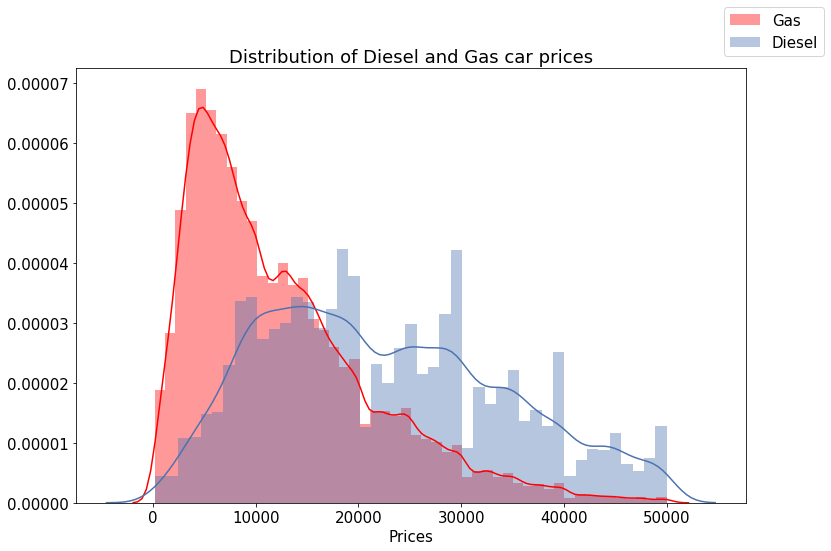

In [40]:
fig = plt.figure(figsize=(12,8))
sns.distplot(gas, color = 'red')
sns.distplot(diesel)
fig.legend(labels=['Gas','Diesel'])
plt.title('Distribution of Diesel and Gas car prices')
plt.xlabel('Prices')

plt.show()

#### Second Hypothesis test

In [41]:
#Null Hypothesis - H0: Mean price of rwd is lesser or equal than the mean price of fwd
#Alternative Hypothesis - HA: Mean price of rwd is greater than the mean price of fwd

rwd = dff[dff.drive == 'rwd'].price
fwd = dff[dff.drive == 'fwd'].price

print(stats.ttest_ind(rwd, fwd))

# Ttest_indResult(statistic=109.39720387405556, pvalue=0.0)

# Reject Null Hypthesis
# p-value << 0.05 
# Mean price of rwd is greater than the mean price of fwd

Ttest_indResult(statistic=109.39720387405556, pvalue=0.0)


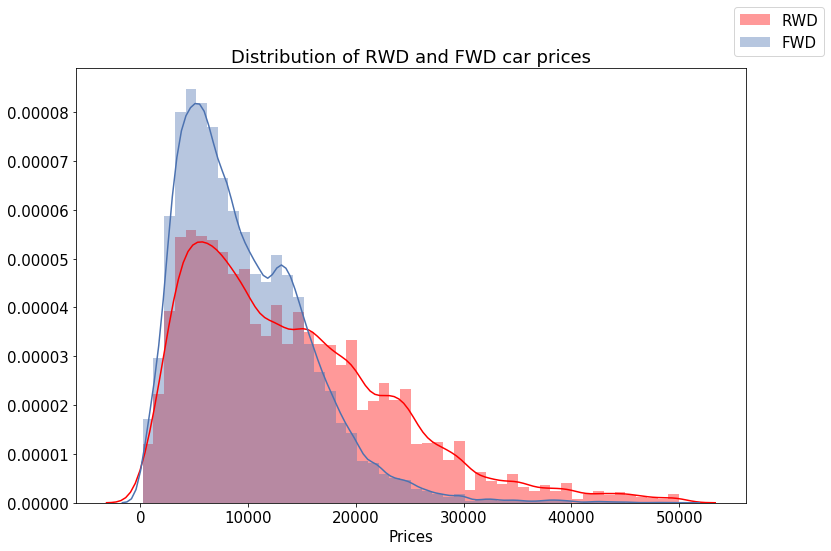

In [42]:
fig = plt.figure(figsize=(12,8))
sns.distplot(rwd, color = 'red')
sns.distplot(fwd)
fig.legend(labels=['RWD','FWD'])
plt.title('Distribution of RWD and FWD car prices')
plt.xlabel('Prices')

plt.show()

#### Third Hypthesis test

In [43]:
# Null Hypothesis: There is s
# Alt-Hypothesis: There is a significant relation between price and condition.


anova = ols('price~condition', data=dff).fit()
anova_table = sm.stats.anova_lm(anova, type=2)
print(anova_table)

# p-value = 0
# F-stat = 2592.142181
# Reject Null Hypothesis
# There is a significant relation between price and condition.

                 df        sum_sq       mean_sq            F  PR(>F)
condition       3.0  6.055538e+11  2.018513e+11  2592.142181     0.0
Residual   231496.0  1.802670e+13  7.787045e+07          NaN     NaN


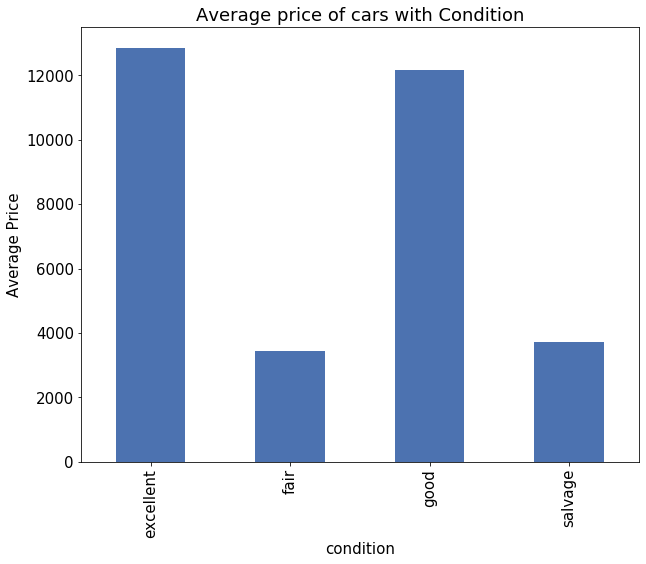

In [44]:
plt.figure(figsize=(10,8))
dff.groupby('condition').price.mean().plot(kind = 'bar')
plt.title('Average price of cars with Condition')
plt.ylabel('Average Price')
plt.show()

### Visualizations

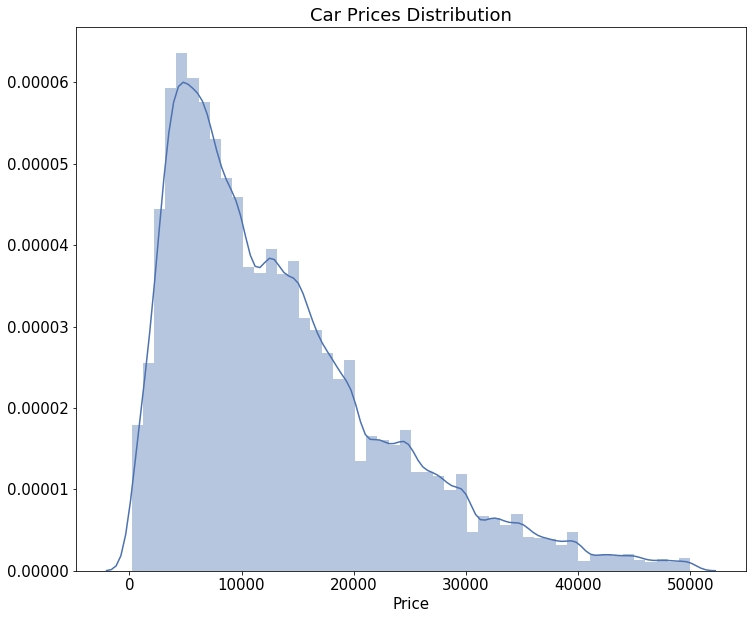

In [45]:
plt.figure(figsize=(12,10))
sns.distplot(df.price)
plt.title('Car Prices Distribution')
plt.xlabel('Price')
plt.show()

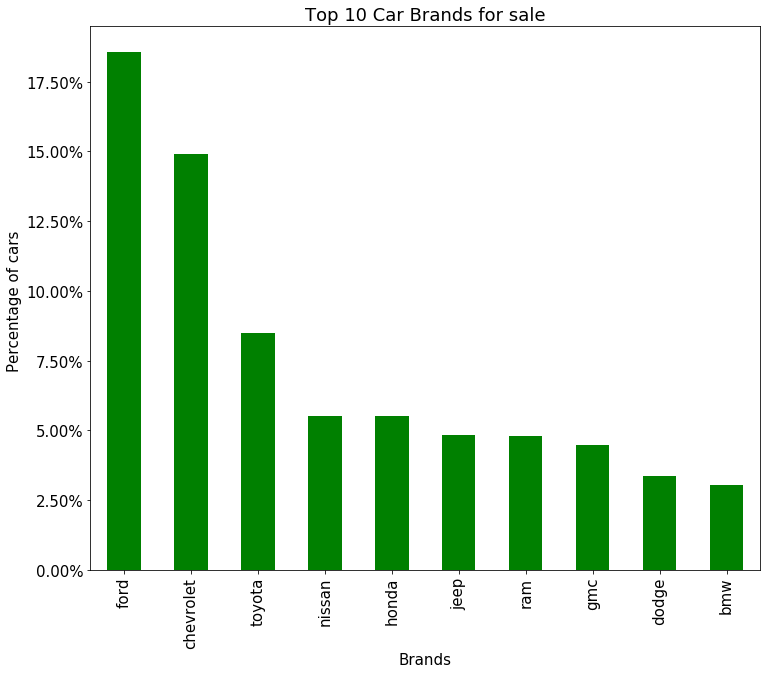

In [46]:
plt.figure(figsize=(12,10))
ax = df['manufacturer'].value_counts(normalize = True).head(10).plot(kind='bar', color = 'green')
plt.title('Top 10 Car Brands for sale')
plt.xlabel('Brands')
plt.ylabel('Percentage of cars ')
vals = ax.get_yticks()
ax.set_yticklabels(['{:,.2%}'.format(x) for x in vals])
plt.show()

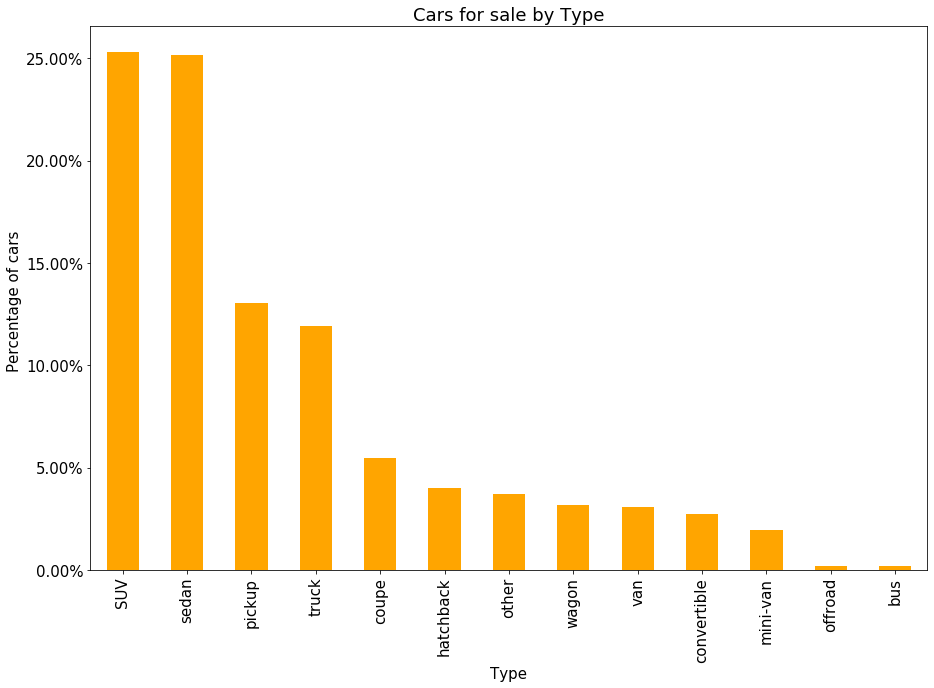

In [47]:
plt.figure(figsize=(15,10))
ax = dff['type'].value_counts(normalize = True).plot(kind='bar', color = 'orange')
plt.title('Cars for sale by Type')
plt.xlabel('Type')
plt.ylabel('Percentage of cars ')
vals = ax.get_yticks()
ax.set_yticklabels(['{:,.2%}'.format(x) for x in vals])
plt.show()

Text(0.5, 1.0, 'Number of cars by Condition')

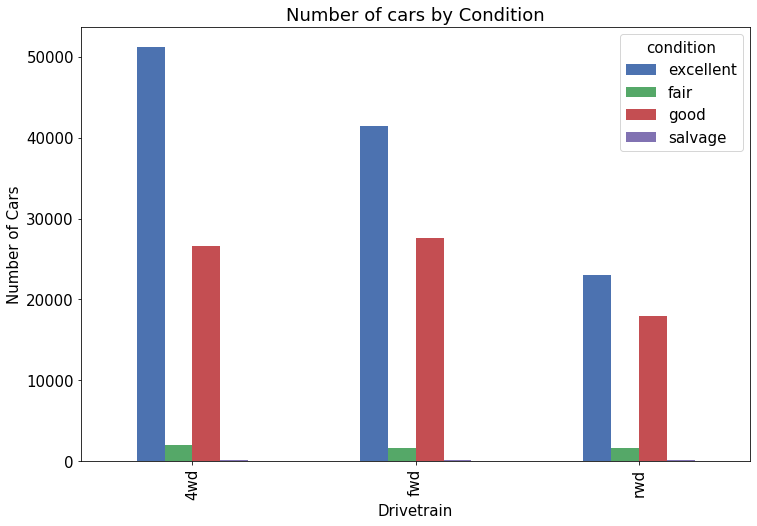

In [48]:

ax = dff.groupby(['drive', 'condition']).price.count().unstack().plot(kind = 'bar',figsize = (12,8) )
plt.ylabel("Number of Cars")
plt.xlabel("Drivetrain")
plt.title('Number of cars by Condition')

Text(0, 0.5, 'Average miles')

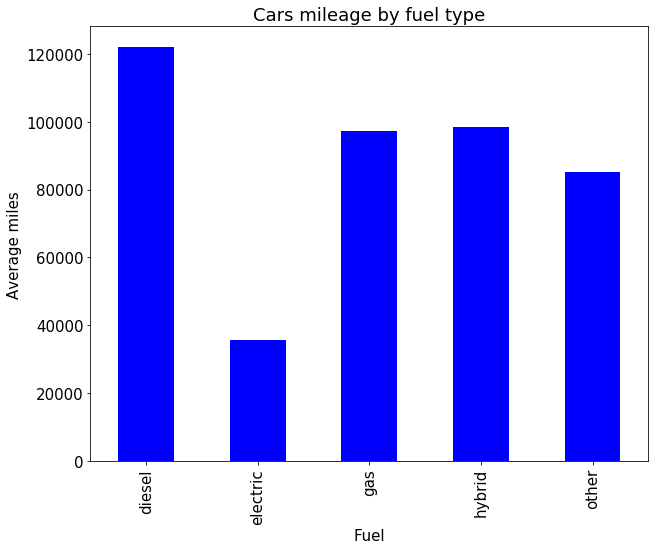

In [49]:
fig = plt.figure(figsize = (10,8))
ax = dff.groupby([ 'fuel']).odometer.median().plot(kind = 'bar', color = 'blue');
plt.title('Cars mileage by fuel type')
plt.xlabel('Fuel')
plt.ylabel('Average miles')

Text(0.5, 1, 'Miles-Price')

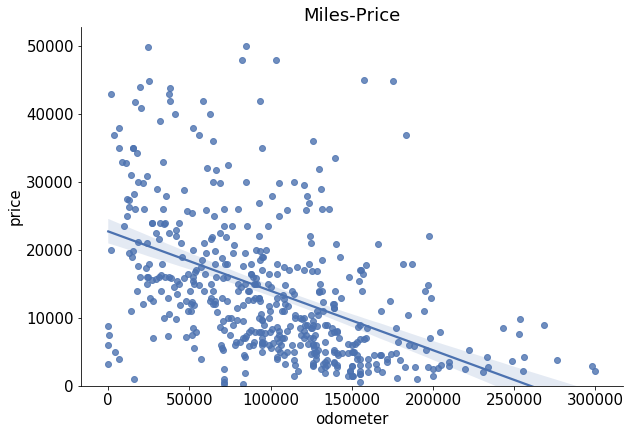

In [122]:
sample = dff.sample(n = 500)
sns.lmplot('odometer', 'price', data=sample[['price','odometer']],height = 6, aspect = 1.5)
plt.ylim(0, None);
plt.title('Miles-Price')

Text(0.5, 1, 'Year-Price')

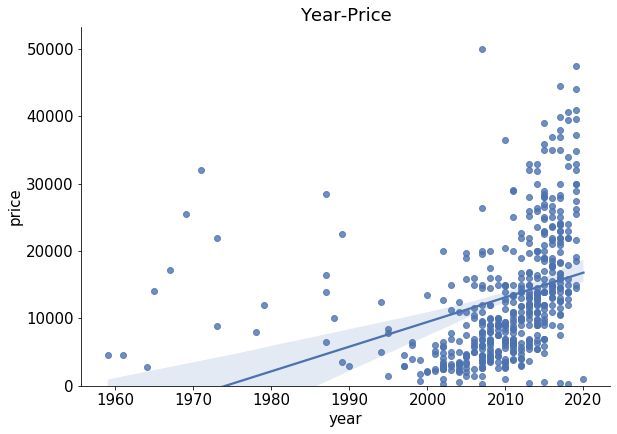

In [123]:
sample = dff.sample(n = 500)
sns.lmplot('year', 'price', data=sample[['price','year']],height = 6, aspect = 1.5)
plt.ylim(0, None);
plt.title('Year-Price')

##  Creating New Columns from Description


In [50]:
df.shape

(387772, 17)

In [51]:
# Going through description to check how many cars have new tires and creating a column for new tires
df['new_tires'] = np.where((df['description'].str.contains('new tire')) |
                           (df['description'].str.contains('NEW TIRE')) |
                           (df['description'].str.contains('New Tire')) |
                           (df['description'].str.contains('new TIRE')) |
                           (df['description'].str.contains('NEW tire')), 1,0) 

In [52]:
df['new_tires'].sum()

23606

In [53]:
df['heated_seats'] = np.where((df['description'].str.contains('HEATED SEAT')) |
                           (df['description'].str.contains('heated seat')) |
                           (df['description'].str.contains('Heated Seat')) |
                           (df['description'].str.contains('heated SEAT')) |
                           (df['description'].str.contains('HEATED seat')), 1,0)

In [54]:
df['heated_seats'].sum()

36464

In [55]:
df['auto_headlight'] = np.where((df['description'].str.contains('automatic headlight')) |
                                (df['description'].str.contains('auto headlight')) |
                                (df['description'].str.contains('AUTOMATIC HEADLIGHT')) |
                                (df['description'].str.contains('Automatic Headlight')) |
                                (df['description'].str.contains('AUTO HEADLIGHT')) |
                                (df['description'].str.contains('Auto Headlight')), 1,0)

In [56]:
df['auto_headlight'].sum()

20579

In [57]:
df['leather'] = np.where((df['description'].str.contains('leather')) |
                          (df['description'].str.contains('Leather'))|
                          (df['description'].str.contains('LEATHER')) , 1,0)

In [58]:
df['leather'].sum()

107756

In [59]:
# Removing Description and model column
df.drop(['description', 'model','state'], axis = 1, inplace = True)


In [60]:
df.columns

Index(['price', 'year', 'manufacturer', 'condition', 'cylinders', 'fuel',
       'odometer', 'title_status', 'transmission', 'drive', 'size', 'type',
       'paint_color', 'age', 'new_tires', 'heated_seats', 'auto_headlight',
       'leather'],
      dtype='object')

### Checking Collinearity

In [61]:
corr_matrix = df.corr().abs()
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))
upper

,price,year,cylinders,odometer,age,new_tires,heated_seats,auto_headlight,leather
price,NaN,0.324747,0.041156,0.501537,0.324747,0.055323,0.131333,0.091522,0.155815
year,NaN,NaN,0.112827,0.267469,1.000000,0.036780,0.105267,0.104230,0.118244
cylinders,NaN,NaN,NaN,0.108996,0.112827,0.036303,0.034170,0.016255,0.061439
odometer,NaN,NaN,NaN,NaN,0.267469,0.048924,0.062084,0.084638,0.039083
age,NaN,NaN,NaN,NaN,NaN,0.036780,0.105267,0.104230,0.118244
new_tires,NaN,NaN,NaN,NaN,NaN,NaN,0.018780,0.023997,0.018040
heated_seats,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.109208,0.346056
auto_headlight,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.196261
leather,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [62]:
to_drop = [column for column in upper.columns if any(upper[column] > 0.9)]
print(to_drop)

['age']


In [63]:
df.columns

Index(['price', 'year', 'manufacturer', 'condition', 'cylinders', 'fuel',
       'odometer', 'title_status', 'transmission', 'drive', 'size', 'type',
       'paint_color', 'age', 'new_tires', 'heated_seats', 'auto_headlight',
       'leather'],
      dtype='object')

In [64]:

dff = df

## Baseline Model

In [65]:
dff.columns
base_features = [ 'odometer','age', 'new_tires', 'heated_seats', 'auto_headlight', 'leather', 'cylinders']

In [66]:
scaler = StandardScaler()
#instantiate a linear regression object
scaler.fit(dff[base_features])
lm = linear_model.LinearRegression()

#fit the linear regression to the data
lm = lm.fit(dff[base_features], target)


print(lm.intercept_)
print(lm.coef_)
print ("R^2 Score:", lm.score(dff[base_features], target))
pred = lm.predict(dff[base_features])
rmse = np.sqrt(metrics.mean_squared_error(target, pred))
print('Root Mean Squared Error:' , rmse)

21582.485530703994
[-7.85357984e-02 -2.09473715e+02 -1.29854771e+03  1.55758774e+03
  3.06531688e+02  1.96194517e+03  3.28037489e+02]
R^2 Score: 0.3180250957446794
Root Mean Squared Error: 7971.247585323107


## Creating Dummy Variables

In [67]:
df.columns

Index(['price', 'year', 'manufacturer', 'condition', 'cylinders', 'fuel',
       'odometer', 'title_status', 'transmission', 'drive', 'size', 'type',
       'paint_color', 'age', 'new_tires', 'heated_seats', 'auto_headlight',
       'leather'],
      dtype='object')

In [68]:
target = df['price']
df =  pd.get_dummies(df, columns=['condition'], drop_first = True )
df =  pd.get_dummies(df, columns=['fuel'], drop_first = True )
df =  pd.get_dummies(df, columns=['title_status'], drop_first = True )
df =  pd.get_dummies(df, columns=['transmission'], drop_first = True )
df =  pd.get_dummies(df, columns=['drive'], drop_first = True )
df =  pd.get_dummies(df, columns=['size'], drop_first = True )
df =  pd.get_dummies(df, columns=['type'], drop_first = True )
df =  pd.get_dummies(df, columns=['paint_color'], drop_first = True )
#df =  pd.get_dummies(df, columns=['state'], drop_first = True )
#df =  pd.get_dummies(df, columns=['cylinders'], drop_first = True )
#df =  pd.get_dummies(df, columns=['manufacturer'], drop_first = True )

In [69]:
df.head()

,price,year,manufacturer,cylinders,odometer,age,new_tires,heated_seats,auto_headlight,leather,condition_fair,condition_good,condition_salvage,fuel_electric,fuel_gas,fuel_hybrid,fuel_other,title_status_lien,title_status_missing,title_status_parts only,title_status_rebuilt,title_status_salvage,transmission_manual,transmission_other,drive_fwd,drive_rwd,size_full-size,size_mid-size,size_sub-compact,type_bus,type_convertible,type_coupe,type_hatchback,type_mini-van,type_offroad,type_other,type_pickup,type_sedan,type_truck,type_van,type_wagon,paint_color_blue,paint_color_brown,paint_color_custom,paint_color_green,paint_color_grey,paint_color_orange,paint_color_purple,paint_color_red,paint_color_silver,paint_color_white,paint_color_yellow
0,3495,2012,jeep,4,104259.0,8,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
1,13750,2014,bmw,0,76237.0,6,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0
2,2300,2001,dodge,6,199000.0,19,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,9000,2004,chevrolet,5,54000.0,16,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
5,500,2010,NaN,0,120757.0,10,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [70]:
df.shape

(387772, 52)

### Feature Selection

In [71]:
dff.corrwith(target).abs()

price             1.000000
year              0.324747
cylinders         0.041156
odometer          0.501537
age               0.324747
new_tires         0.055323
heated_seats      0.131333
auto_headlight    0.091522
leather           0.155815
dtype: float64

In [72]:
df.columns

Index(['price', 'year', 'manufacturer', 'cylinders', 'odometer', 'age',
       'new_tires', 'heated_seats', 'auto_headlight', 'leather',
       'condition_fair', 'condition_good', 'condition_salvage',
       'fuel_electric', 'fuel_gas', 'fuel_hybrid', 'fuel_other',
       'title_status_lien', 'title_status_missing', 'title_status_parts only',
       'title_status_rebuilt', 'title_status_salvage', 'transmission_manual',
       'transmission_other', 'drive_fwd', 'drive_rwd', 'size_full-size',
       'size_mid-size', 'size_sub-compact', 'type_bus', 'type_convertible',
       'type_coupe', 'type_hatchback', 'type_mini-van', 'type_offroad',
       'type_other', 'type_pickup', 'type_sedan', 'type_truck', 'type_van',
       'type_wagon', 'paint_color_blue', 'paint_color_brown',
       'paint_color_custom', 'paint_color_green', 'paint_color_grey',
       'paint_color_orange', 'paint_color_purple', 'paint_color_red',
       'paint_color_silver', 'paint_color_white', 'paint_color_yellow'],
     

In [73]:
features = ['age', 'odometer', 'new_tires', 'heated_seats',
       'auto_headlight', 'leather', 'cylinders',
       'condition_fair', 'condition_good', 'condition_salvage',
       'fuel_electric', 'fuel_gas', 'fuel_hybrid', 'fuel_other',
       'title_status_lien', 'title_status_missing', 'title_status_parts only',
       'title_status_rebuilt', 'title_status_salvage', 'transmission_manual',
       'transmission_other', 'drive_fwd', 'drive_rwd', 'size_full-size',
       'size_mid-size', 'size_sub-compact', 'type_bus', 'type_convertible',
       'type_coupe', 'type_hatchback', 'type_mini-van', 'type_offroad',
       'type_other', 'type_pickup', 'type_sedan', 'type_truck', 'type_van',
       'type_wagon', 'paint_color_blue', 'paint_color_brown',
       'paint_color_custom', 'paint_color_green', 'paint_color_grey',
       'paint_color_orange', 'paint_color_purple', 'paint_color_red',
       'paint_color_silver', 'paint_color_white', 'paint_color_yellow']

df_features = df[features]

corr_matrix = df_features.corr().abs()
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))
#upper

In [74]:
to_drop = [column for column in upper.columns if any(upper[column] > 0.9)]
print(to_drop)

[]


In [75]:
df_features.isna().sum().any()

False

In [76]:
# vif = pd.DataFrame()
# vif["VIF Factor"] = [variance_inflation_factor(df_features.values, i) for i in range(df_features.shape[1])]
# vif["features"] = df_features.columns
# vif.round(1)

In [77]:
# to_drop =  list(vif[vif['VIF Factor'] > 9]['features'])
# print(to_drop)

In [78]:
#df_features.drop( columns = ['fuel_gas'], inplace = True)

In [79]:
#df_features.columns


### Train Test Split

In [80]:
scaler = StandardScaler()
scaler2 = MinMaxScaler()
#call train_test_split on the data and capture the results
X_train, X_test, y_train, y_test = train_test_split(df_features, target, random_state=34,test_size=0.2)

scaler2.fit(X_train)
lm = linear_model.LinearRegression()
lm = lm.fit(X_train, y_train)

In [81]:
# testing the model on training data and getting the rmse
y_train_pred = lm.predict(X_train)
train_rmse = np.sqrt(metrics.mean_squared_error(y_train, y_train_pred))
print('Root Mean Squared Error:' , train_rmse)

Root Mean Squared Error: 6436.7179671973845


In [82]:
y_pred = lm.predict(X_test)

In [83]:
test_rmse = np.sqrt(metrics.mean_squared_error(y_test, y_pred))
print('Root Mean Squared Error:' + str(np.sqrt(metrics.mean_squared_error(y_test, y_pred))))

Root Mean Squared Error:6414.529784255926


In [84]:
print('Training: ', int(train_rmse), "vs. Testing: ", int(test_rmse))

Training:  6436 vs. Testing:  6414


### Using k best

In [85]:
selector = SelectKBest(f_regression, k = 20)
selector.fit(X_train, y_train)

selected_columns = X_train.columns[selector.get_support()]
removed_columns = X_train.columns[~selector.get_support()]

In [86]:
#list(removed_columns)

In [87]:
#list(selected_columns)

In [124]:
#instantiate a linear regression object
lm_kbest = LinearRegression()

#fit the linear regression to the data
lm_kbest = lm_kbest.fit(X_train[selected_columns], y_train)

y_train_kbest = lm_kbest.predict(X_train[selected_columns])


trainK_rmse = np.sqrt(metrics.mean_squared_error(y_train, y_train_kbest))


print('Training Root Mean Squared Error:' , trainK_rmse)

y_kbest = lm_kbest.predict(X_test[selected_columns])

testK_rmse = np.sqrt(metrics.mean_squared_error(y_test, y_kbest))

print('Testing Root Mean Squared Error:' , testK_rmse)


print('Original: ', test_rmse, "vs. KBest: ", testK_rmse)
lm_kbest.score(X_train[selected_columns], y_train)

Training Root Mean Squared Error: 7938.828346358871
Testing Root Mean Squared Error: 7901.066385654935
Original:  7898.574404482186 vs. KBest:  7901.066385654935


0.3244354781918187

#### RMSE with k best is worse than regular


### Trying Recursive feature elimination

In [89]:
ols = linear_model.LinearRegression()
# Create recursive feature eliminator that scores features by mean squared errors
selector = RFECV(estimator = ols , step=1, cv=5, scoring='neg_mean_squared_error')

# Fit recursive feature eliminator 
selector.fit(X_train, y_train)


RFECV(cv=5,
      estimator=LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
                                 normalize=False),
      min_features_to_select=1, n_jobs=None, scoring='neg_mean_squared_error',
      step=1, verbose=0)

In [90]:
selected_rfe = X_train.columns[selector.support_]
removed_rfe = X_train.columns[~selector.support_]


In [91]:
list(removed_rfe)

[]

In [92]:
len(list(selected_rfe))

49

In [93]:
#instantiate a linear regression object
lm_rfe = LinearRegression()

#fit the linear regression to the data
lm_rfe = lm_rfe.fit(X_train[selected_rfe], y_train)

y_rfe = lm_rfe.predict(X_train[selected_rfe])


trainRFE_rmse = np.sqrt(metrics.mean_squared_error(y_train, y_rfe))


print('Training Root Mean Squared Error:' , trainRFE_rmse)

y_pred_rfe = lm_rfe.predict(X_test[selected_rfe])

testRFE_rmse = np.sqrt(metrics.mean_squared_error(y_test, y_pred_rfe))

print('Testing Root Mean Squared Error:' , testRFE_rmse)

print('Original: ', test_rmse, "vs. KBest: ", testK_rmse, "vs. RFE: ", testRFE_rmse)

Training Root Mean Squared Error: 6436.7179671973845
Testing Root Mean Squared Error: 6414.529784255926
Original:  6414.529784255926 vs. KBest:  6563.510734117032 vs. RFE:  6414.529784255926


In [94]:
X_train.head()

,age,odometer,new_tires,heated_seats,auto_headlight,leather,cylinders,condition_fair,condition_good,condition_salvage,fuel_electric,fuel_gas,fuel_hybrid,fuel_other,title_status_lien,title_status_missing,title_status_parts only,title_status_rebuilt,title_status_salvage,transmission_manual,transmission_other,drive_fwd,drive_rwd,size_full-size,size_mid-size,size_sub-compact,type_bus,type_convertible,type_coupe,type_hatchback,type_mini-van,type_offroad,type_other,type_pickup,type_sedan,type_truck,type_van,type_wagon,paint_color_blue,paint_color_brown,paint_color_custom,paint_color_green,paint_color_grey,paint_color_orange,paint_color_purple,paint_color_red,paint_color_silver,paint_color_white,paint_color_yellow
109328,50,56311.5,0,0,0,0,8,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
420092,22,93183.0,0,0,0,0,6,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
86239,13,152675.0,0,0,0,0,6,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
27167,11,159000.0,0,0,0,1,6,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
260036,16,149000.0,0,0,0,0,4,0,1,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


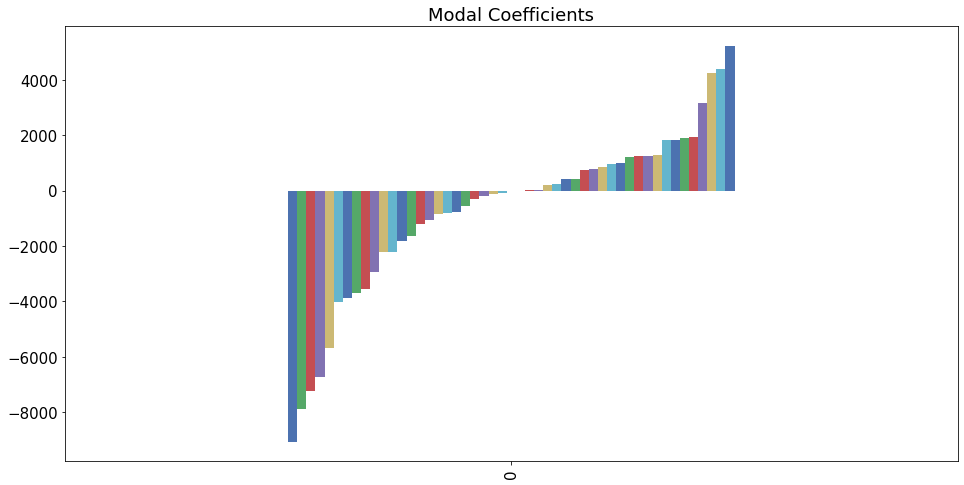

In [95]:
coef = pd.DataFrame(data=lm_rfe.coef_ ).T
coef.columns = selected_rfe

model_coef = coef.T.sort_values(by=0).T
model_coef.plot(kind='bar', title='Modal Coefficients', legend=False, figsize=(16,8),)

### Using Lasso

In [96]:
## training the model

lasso = Lasso(alpha = 0.1, normalize=False)

lasso.fit(X_train,y_train)

y_train_pred = lasso.predict(X_train)
y_pred = lasso.predict(X_test)

train_rmse = np.sqrt(metrics.mean_squared_error(y_train, y_train_pred))
test_rmse = np.sqrt(metrics.mean_squared_error(y_test, y_pred))
print('Training Error: '+ str(train_rmse) )
print('Testing Error: '+ str(test_rmse) )


Training Error: 6436.724092199892
Testing Error: 6414.481750899225


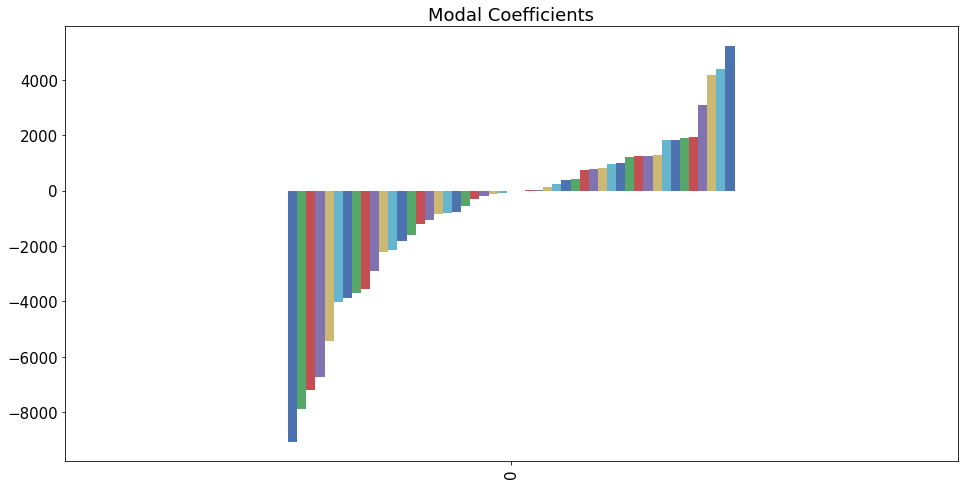

In [97]:
lasso_coef01 = pd.DataFrame(data=lasso.coef_).T
lasso_coef01.columns = X_train.columns
lasso_coef01 = lasso_coef01.T.sort_values(by=0).T
lasso_coef01.plot(kind='bar', title='Modal Coefficients', legend=False, figsize=(16,8))

### Polynomial

In [98]:
poly_features =  [ 'odometer','age', 'new_tires', 'heated_seats', 'auto_headlight', 'leather', 'cylinders']
poly_df = dff[poly_features]
poly = PolynomialFeatures(degree=2, include_bias=False)
poly_data = poly.fit_transform(poly_df)
poly_columns = poly.get_feature_names(poly_df.columns)
df_poly = pd.DataFrame(poly_data, columns=poly_columns)
#df_poly.head()

### Checking multi collinearity

In [99]:
corr_matrix = df_poly.corr().abs()
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))
#upper

In [100]:
to_drop = [column for column in upper.columns if any(upper[column] > 0.9)]
print(to_drop)

['odometer^2', 'age heated_seats', 'age auto_headlight', 'new_tires^2', 'heated_seats^2', 'auto_headlight^2', 'leather^2', 'cylinders^2']


In [101]:
df_poly.drop(columns =  to_drop, inplace = True)

In [102]:
vif = pd.DataFrame()
vif["VIF Factor"] = [variance_inflation_factor(df_poly.values, i) for i in range(df_poly.shape[1])]
vif["features"] = df_poly.columns
vif.round(1)

,VIF Factor,features
0,13.0,odometer
1,31.2,age
2,9.2,new_tires
3,8.8,heated_seats
4,6.5,auto_headlight
5,9.2,leather
6,10.6,cylinders
7,13.8,odometer age
8,6.1,odometer new_tires
9,5.2,odometer heated_seats


In [103]:
to_drop =  list(vif[vif['VIF Factor'] > 9]['features'])
print(to_drop)

['odometer', 'age', 'new_tires', 'leather', 'cylinders', 'odometer age', 'odometer cylinders', 'age^2']


In [104]:
df_poly.drop(columns =  ['new_tires', 'cylinders', 'odometer age', 'odometer cylinders', 'age^2'], inplace = True)

### Train test for df poly

In [105]:
scaler = StandardScaler()
#call train_test_split on the data and capture the results
X_train, X_test, y_train, y_test = train_test_split(df_poly, target, random_state=34,test_size=0.2)
scaler.fit(X_train)
print("Training set - Features: ", X_train.shape, "Target: ", y_train.shape)
print("Testing set - Features: ", X_test.shape, "Target: ",y_test.shape)
lm = linear_model.LinearRegression()
lm = lm.fit(X_train, y_train)
print ("R^2 Score:", lm.score(X_train, y_train))
y_train_pred = lm.predict(X_train)
train_rmse = np.sqrt(metrics.mean_squared_error(y_train, y_train_pred))
print('Training RMSE: ' , train_rmse)
test_rmse = np.sqrt(metrics.mean_squared_error(y_test, y_pred))
print('Testing RMSE: ' + str(test_rmse))

Training set - Features:  (310217, 22) Target:  (310217,)
Testing set - Features:  (77555, 22) Target:  (77555,)
R^2 Score: 0.3247933901282331
Training RMSE:  7936.7250847342175
Testing RMSE: 6414.481750899225


### Running k best on Polynomail Interaction dataset

In [106]:
selector = SelectKBest(f_regression, k = 20)
selector.fit(X_train, y_train)
selected_columns = X_train.columns[selector.get_support()]
removed_columns = X_train.columns[~selector.get_support()]
lm_kbest = LinearRegression()
lm_kbest = lm_kbest.fit(X_train[selected_columns], y_train)
y_train_kbest = lm_kbest.predict(X_train[selected_columns])
trainK_rmse = np.sqrt(metrics.mean_squared_error(y_train, y_train_kbest))
print('Training Root Mean Squared Error:' , trainK_rmse)
y_kbest = lm_kbest.predict(X_test[selected_columns])
testK_rmse = np.sqrt(metrics.mean_squared_error(y_test, y_kbest))
print('Testing Root Mean Squared Error:' , testK_rmse)
print('Original: ', test_rmse, "vs. KBest: ", testK_rmse)

Training Root Mean Squared Error: 7938.828346358871
Testing Root Mean Squared Error: 7901.066385654935
Original:  6414.481750899225 vs. KBest:  7901.066385654935


### Running Lasso on Polynomial interaction dataset

In [107]:
scaler = StandardScaler()
X_train, X_test, y_train, y_test = train_test_split(df_poly, target, random_state=34,test_size=0.2)
scaler.fit(X_train)
lasso = Lasso(alpha = 0.01, normalize=False)
lasso.fit(X_train,y_train)
y_train_pred = lasso.predict(X_train)
y_pred = lasso.predict(X_test)
train_rmse = np.sqrt(metrics.mean_squared_error(y_train, y_train_pred))
test_rmse = np.sqrt(metrics.mean_squared_error(y_test, y_pred))
print('Training Error: '+ str(train_rmse) )
print('Testing Error: '+ str(test_rmse) )

Training Error: 7936.725093539281
Testing Error: 7898.574404482186


In [108]:
# Lasso on df_poly
scaler = StandardScaler()
scaler.fit(df_poly)

lasso = Lasso(alpha = 0.1, normalize=False)

lasso.fit(df_poly,target)

y_pred = lasso.predict(df_poly)

rmse = np.sqrt(metrics.mean_squared_error(target, y_pred))

print('RMSE '+ str(rmse) )


RMSE 7929.010676378284


In [109]:
# Lasso on Whole dataset
scaler = StandardScaler()
scaler.fit(df_features)

lasso = Lasso(alpha = 0.1, normalize=False)

lasso.fit(df_features,target)

y_pred = lasso.predict(df_features)

rmse = np.sqrt(metrics.mean_squared_error(target, y_pred))

print('RMSE: '+ str(rmse) )
print('R-Squared: '+ str(lasso.score(df_features,target)))

RMSE: 6432.201519703276
R-Squared: 0.555946721075971


In [110]:

scaler.fit(df_features)
lm = linear_model.LinearRegression()
lm = lm.fit(df_features, target)
pred = lm.predict(df_features)

y_pred = lm.predict(df_features)
t_rmse = np.sqrt(metrics.mean_squared_error(target, pred))
print('Root Mean Squared Error: ' + str(t_rmse))


Root Mean Squared Error: 6432.195328946938


In [111]:
len(df_features)

387772

Text(0, 0.5, 'Age ')

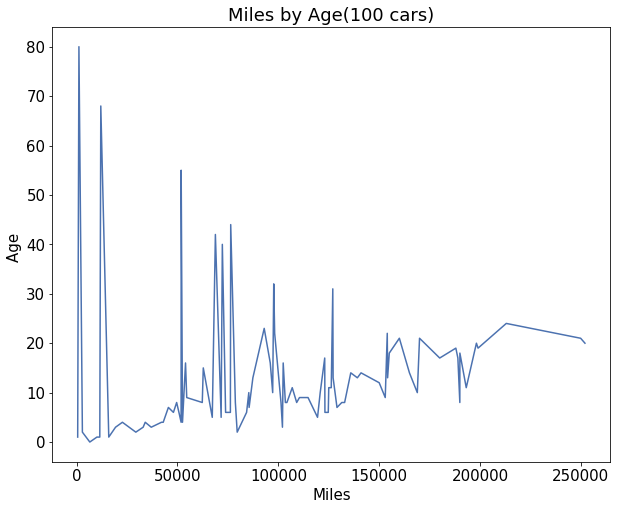

In [145]:
fig = plt.figure(figsize = (10,8))
sns.lineplot(y ='age', x ='odometer', data = dff.head(100))
plt.title('Miles by Age(100 cars)')
plt.xlabel('Miles')
plt.ylabel('Age ')

In [147]:
dff.price.describe()

count    387772.000000
mean      13390.976048
std        9652.563374
min         200.000000
25%        5990.000000
50%       10995.000000
75%       18450.000000
max       50000.000000
Name: price, dtype: float64